# Retrospective analysis

In [21]:
import os
import numpy as np
import seaborn as sns
from pymbar import BAR
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from glob import glob
import pickle
from simtk.openmm import unit
import bz2
from beryllium import plotting, stats
import pandas as pd
import json
import tqdm
from openmmtools.constants import kB
import networkx as nx
import random
temperature = 300.0 * unit.kelvin
kT = kB * temperature

In [22]:
with bz2.BZ2File('../data/work-13420.pkl.bz2', 'r') as infile:
    work = pickle.load(infile)

In [23]:
work.replace([np.inf, -np.inf], np.nan)
work = work.dropna()

def _strip_outliers(w,n_devs=100):
    w = [x for x in w if np.abs(x) < 10**4]
    mean = np.mean(w)
    std = np.std(w)
    good_w = [x for x in w if np.abs(x-mean) < n_devs*std]
    return np.asarray(good_w)

In [24]:
retro_jsons = [x for x in os.listdir('/Users/brucemah/bin/covid-moonshot-new/synthetic-enumeration/') if 'retro' in x or 'fastgrant' in x and 'json' in x]

In [25]:
details = {}

for x in retro_jsons:
    with open(f'/Users/brucemah/bin/covid-moonshot-new/synthetic-enumeration/{x}', 'r') as f:
        new = json.load(f)
        details = {**details, **new}
        print(len(details))

284
572
608
768


In [26]:
projects = {
    'complex' : 'PROJ13420',
    'solvent' : 'PROJ13421'}

import time
plotting = False

def _get_works(df,run,project,GEN=None):
    works = df[(df['RUN']==run)]
    
    if GEN:
        works = works[works['GEN']==GEN]

    f = works[works['PROJ']==project].forward_work
    r = works[works['PROJ']==project].reverse_work   
    return f, r

n_bootstrap = 100
for d in tqdm.tqdm(details.values()):
    RUN = d['directory']
    if plotting:
        fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
    for i, phase in enumerate(projects.keys()):
        if plotting:
            axes[i].set_title(phase)
        
        all_forward = []
        all_reverse = []
        # There will be 6 gens for this project I think
        for gen_id in range(0,7):
            f_works, r_works = _get_works(work,RUN,projects[phase],GEN=f'GEN{gen_id}')
            f_works = _strip_outliers(f_works)       
            r_works = _strip_outliers(r_works)
            d[f'{phase}_fes_GEN{gen_id}'] = []
            d[f'{phase}_dfes_GEN{gen_id}'] = []

            if len(f_works) > 10 and len(r_works) > 10:
                for _ in range(n_bootstrap):
                    f = random.choices(f_works, k=len(f_works))
                    r = random.choices(r_works, k=len(r_works))
                    fe, err = BAR(np.asarray(f), np.asarray(f)) 
                    d[f'{phase}_fes_GEN{gen_id}'].append(fe)
                    d[f'{phase}_dfes_GEN{gen_id}'].append(err)

            all_forward.extend(f_works)
            all_reverse.extend(r_works)
        if len(all_forward) < 10:
            print(f'Cant calculate {RUN} {phase}')
            continue
        if len(all_reverse) < 10:
            print(f'Cant calculate {RUN} {phase}')
            continue
        if plotting:
            sns.kdeplot(all_forward,shade=True,color='cornflowerblue',ax=axes[i])
            sns.rugplot(all_forward,ax=axes[i],color='cornflowerblue',alpha=0.5,label=f'forward : N={len(f_works)}')
            sns.rugplot(all_forward,ax=axes[i],color='darkblue',label=f'forward (gen0) : N={len(f_works)}')
            sns.rugplot([-x for x in all_reverse],ax=axes[i],color='mediumvioletred',label=f'reverse (gen0) : N={len(r_works)}')
            sns.kdeplot([-x for x in all_reverse],shade=True,color='hotpink',ax=axes[i])
            sns.rugplot([-x for x in all_reverse],ax=axes[i],color='hotpink',alpha=0.5,label=f'reverse : N={len(r_works)}')

        if any([True for x in [all_reverse, all_forward] if len(x) < 20]):
            print(f'Cant calculate {RUN} {phase}')
        else:
            # TODO add bootstrapping here
            d[f'{phase}_fes'] = BAR(np.asarray(all_forward), np.asarray(all_reverse))
              
        
    if plotting:    
        fig.suptitle(f"{RUN}: {d['protein'].split('_')[0]} {d['start']}-{d['end']}", fontsize=16)
        fig.subplots_adjust(top=0.9,wspace=0.15)
        axes[0].legend()
        axes[1].legend()
        plt.show()

  0%|          | 0/768 [00:00<?, ?it/s]/Users/brucemah/miniconda3/lib/python3.6/site-packages/pymbar/bar.py:373: RuntimeWarning:

invalid value encountered in sqrt

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars

  4%|▍         | 32/768 [00:54<20:56,  1.71s/it]

Cant calculate RUN7833 complex


  4%|▍         | 33/768 [00:56<19:37,  1.60s/it]

Cant calculate RUN7833 solvent


  4%|▍         | 34/768 [00:57<19:57,  1.63s/it]

Cant calculate RUN7835 complex


  5%|▍         | 35/768 [00:59<18:57,  1.55s/it]

Cant calculate RUN7835 solvent


 14%|█▍        | 111/768 [03:08<17:59,  1.64s/it]

Cant calculate RUN7911 solvent


 15%|█▍        | 113/768 [03:12<17:20,  1.59s/it]

Cant calculate RUN7913 solvent


 15%|█▍        | 114/768 [03:13<17:44,  1.63s/it]

Cant calculate RUN7915 complex


 15%|█▍        | 115/768 [03:15<17:01,  1.56s/it]

Cant calculate RUN7915 solvent


 23%|██▎       | 174/768 [04:56<16:57,  1.71s/it]

Cant calculate RUN7975 complex


 23%|██▎       | 175/768 [04:57<15:54,  1.61s/it]

Cant calculate RUN7975 solvent


 23%|██▎       | 176/768 [04:59<16:13,  1.64s/it]

Cant calculate RUN7977 complex


 23%|██▎       | 177/768 [05:00<15:19,  1.56s/it]

Cant calculate RUN7977 solvent


 33%|███▎      | 252/768 [07:24<15:57,  1.86s/it]

Cant calculate RUN8053 complex


 33%|███▎      | 253/768 [07:25<14:48,  1.73s/it]

Cant calculate RUN8053 solvent


 33%|███▎      | 254/768 [07:27<14:45,  1.72s/it]

Cant calculate RUN8055 complex


 33%|███▎      | 255/768 [07:28<14:05,  1.65s/it]

Cant calculate RUN8055 solvent


 33%|███▎      | 257/768 [07:31<13:46,  1.62s/it]

Cant calculate RUN8057 solvent


 41%|████▏     | 318/768 [09:11<11:47,  1.57s/it]

Cant calculate RUN8119 complex


 42%|████▏     | 319/768 [09:13<11:18,  1.51s/it]

Cant calculate RUN8119 solvent


 42%|████▏     | 320/768 [09:14<11:24,  1.53s/it]

Cant calculate RUN8121 complex


 42%|████▏     | 321/768 [09:16<11:00,  1.48s/it]

Cant calculate RUN8121 solvent


 52%|█████▏    | 397/768 [11:22<10:03,  1.63s/it]

Cant calculate RUN8197 solvent


 52%|█████▏    | 399/768 [11:26<09:41,  1.58s/it]

Cant calculate RUN8199 solvent


 52%|█████▏    | 401/768 [11:29<09:31,  1.56s/it]

Cant calculate RUN8201 solvent


 58%|█████▊    | 442/768 [12:39<09:15,  1.71s/it]

Cant calculate RUN8243 complex


 58%|█████▊    | 443/768 [12:40<08:37,  1.59s/it]

Cant calculate RUN8243 solvent
Cant calculate RUN8244 complex


 58%|█████▊    | 444/768 [12:42<08:12,  1.52s/it]

Cant calculate RUN8244 solvent


 60%|██████    | 462/768 [13:12<08:46,  1.72s/it]

Cant calculate RUN8263 complex


 60%|██████    | 463/768 [13:14<08:11,  1.61s/it]

Cant calculate RUN8263 solvent


 60%|██████    | 464/768 [13:16<08:20,  1.65s/it]

Cant calculate RUN8265 complex


 61%|██████    | 465/768 [13:17<07:53,  1.56s/it]

Cant calculate RUN8265 solvent


 61%|██████▏   | 472/768 [13:29<08:23,  1.70s/it]

Cant calculate RUN8273 complex


 62%|██████▏   | 473/768 [13:30<07:51,  1.60s/it]

Cant calculate RUN8273 solvent
Cant calculate RUN8274 complex


 62%|██████▏   | 474/768 [13:32<07:26,  1.52s/it]

Cant calculate RUN8274 solvent


 65%|██████▌   | 500/768 [14:17<07:57,  1.78s/it]

Cant calculate RUN8301 complex


 65%|██████▌   | 501/768 [14:18<07:20,  1.65s/it]

Cant calculate RUN8301 solvent
Cant calculate RUN8302 complex


 65%|██████▌   | 502/768 [14:20<06:56,  1.57s/it]

Cant calculate RUN8302 solvent
Cant calculate RUN8303 complex


 65%|██████▌   | 503/768 [14:21<06:40,  1.51s/it]

Cant calculate RUN8303 solvent
Cant calculate RUN8304 complex


 66%|██████▌   | 504/768 [14:22<06:26,  1.46s/it]

Cant calculate RUN8304 solvent


 70%|███████   | 540/768 [15:27<06:44,  1.77s/it]

Cant calculate RUN8341 complex


 70%|███████   | 541/768 [15:28<06:14,  1.65s/it]

Cant calculate RUN8341 solvent


 71%|███████   | 542/768 [15:30<06:21,  1.69s/it]

Cant calculate RUN8343 complex


 71%|███████   | 543/768 [15:31<05:57,  1.59s/it]

Cant calculate RUN8343 solvent


 71%|███████   | 544/768 [15:33<06:09,  1.65s/it]

Cant calculate RUN8345 complex


 71%|███████   | 545/768 [15:34<05:49,  1.57s/it]

Cant calculate RUN8345 solvent


 79%|███████▉  | 608/768 [17:38<05:40,  2.13s/it]

Cant calculate RUN7641 complex


 79%|███████▉  | 609/768 [17:39<05:13,  1.97s/it]

Cant calculate RUN7641 solvent


 79%|███████▉  | 610/768 [17:41<05:03,  1.92s/it]

Cant calculate RUN7643 complex


 80%|███████▉  | 611/768 [17:43<04:50,  1.85s/it]

Cant calculate RUN7643 solvent


 81%|████████▏ | 624/768 [18:08<04:40,  1.95s/it]

Cant calculate RUN7657 complex


 81%|████████▏ | 625/768 [18:10<04:29,  1.89s/it]

Cant calculate RUN7657 solvent


 82%|████████▏ | 626/768 [18:12<04:31,  1.91s/it]

Cant calculate RUN7659 complex


 82%|████████▏ | 627/768 [18:14<04:06,  1.75s/it]

Cant calculate RUN7659 solvent


 84%|████████▎ | 643/768 [18:45<03:53,  1.87s/it]

Cant calculate RUN7676 complex


 84%|████████▍ | 644/768 [18:46<03:33,  1.72s/it]

Cant calculate RUN7676 solvent
Cant calculate RUN7677 complex


 84%|████████▍ | 645/768 [18:48<03:18,  1.61s/it]

Cant calculate RUN7677 solvent


 90%|████████▉ | 688/768 [20:04<02:17,  1.71s/it]

Cant calculate RUN7721 complex


 90%|████████▉ | 689/768 [20:05<02:06,  1.60s/it]

Cant calculate RUN7721 solvent


 90%|████████▉ | 690/768 [20:07<02:07,  1.63s/it]

Cant calculate RUN7723 complex


 90%|████████▉ | 691/768 [20:08<01:59,  1.55s/it]

Cant calculate RUN7723 solvent


 92%|█████████▏| 704/768 [20:30<01:48,  1.70s/it]

Cant calculate RUN7737 complex


 92%|█████████▏| 705/768 [20:32<01:40,  1.60s/it]

Cant calculate RUN7737 solvent


 92%|█████████▏| 706/768 [20:33<01:41,  1.63s/it]

Cant calculate RUN7739 complex


 92%|█████████▏| 707/768 [20:35<01:34,  1.55s/it]

Cant calculate RUN7739 solvent


 94%|█████████▍| 720/768 [20:57<01:21,  1.71s/it]

Cant calculate RUN7753 complex


 94%|█████████▍| 721/768 [20:58<01:15,  1.60s/it]

Cant calculate RUN7753 solvent


 94%|█████████▍| 723/768 [21:02<01:14,  1.65s/it]

Cant calculate RUN7756 complex


 94%|█████████▍| 724/768 [21:03<01:08,  1.56s/it]

Cant calculate RUN7756 solvent


 94%|█████████▍| 725/768 [21:05<01:08,  1.60s/it]

Cant calculate RUN7758 complex


 95%|█████████▍| 726/768 [21:06<01:04,  1.53s/it]

Cant calculate RUN7758 solvent


100%|██████████| 768/768 [22:18<00:00,  1.74s/it]


In [27]:
for d in details.values():
#     print(d['start'], d['end'])
#     print(d['start_title'], d['end_title'])
    if 'TRY-UNI-2eddb1ff-7' not in [d['start_title'], d['end_title']]:
        print(d)

In [28]:
all_molecules = [d['start_title'] for d in details.values()] + [d['end_title'] for d in details.values()]
all_molecules = set(all_molecules)

index_to_title = {i:t for i,t in enumerate(all_molecules)}
title_to_index = {t:i for i,t in enumerate(all_molecules)}

* Which is more accurate? Backwards (docked to X-ray) or forwards (Xray to docked)?
* Which is more accurate? Cys145/His45, or Cys145(-)/His45(+)?
* How well can we predict loss of affinity? Gain or maintenance of affinity?
* For the small subset with IC50 data, do we have a numerical accuracy in DeltaDeltaG we could report?

In [29]:
import networkx as nx

protein_files = {'../receptors/monomer/Mpro-x2646_0_bound-protein.pdb':'neutral','../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb':'charged'}

graphs = {'neutral-f':nx.DiGraph(),'neutral-r':nx.DiGraph(),'neutral-both':nx.DiGraph(),'charged-f':nx.DiGraph(),'charged-r':nx.DiGraph(),'charged-both':nx.DiGraph()}

for d in details.values():
    if 'complex_fes' in d and 'solvent_fes' in d:  
        protein = d['protein']
        DDG = ((d['solvent_fes'][0] - d['complex_fes'][0])*kT).value_in_unit(unit.kilocalories_per_mole) 
        if np.abs(DDG) > 100:
            continue
        dDDG = ((d['solvent_fes'][1]**0.5 + d['complex_fes'][1]**0.5)**2*kT).value_in_unit(unit.kilocalories_per_mole)
        if d['start_title'] == 'TRY-UNI-2eddb1ff-7':
            graph = graphs[f'{protein_files[protein]}-f']
        else:
            graph = graphs[f'{protein_files[protein]}-r']
        graph.add_edge(d['start_title'],d['end_title'],calc_DDG=DDG, calc_dDDG=dDDG,exp_DDG=0.,exp_dDDG=0.1)
        
        graph = graphs[f'{protein_files[protein]}-both']
        graph.add_edge(d['start_title'],d['end_title'],calc_DDG=DDG, calc_dDDG=dDDG,exp_DDG=0.,exp_dDDG=0.1)

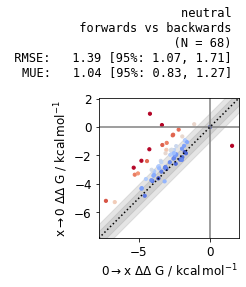

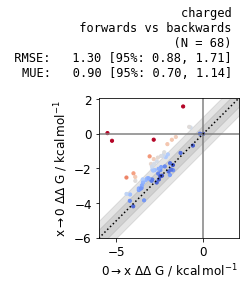

In [30]:
from beryllium import plotting, stats

graphs['neutral-comb'] = nx.DiGraph()
graphs['charged-comb'] = nx.DiGraph()

for bi in ['neutral-both','charged-both']:
    x = []
    y = []
    g = graphs[bi]
    for edge in g.edges(data=True):
        if edge[0] == 'TRY-UNI-2eddb1ff-7':
            if g.has_edge(edge[1],edge[0]):
                x.append(edge[2]['calc_DDG'])
                y.append(-g.get_edge_data(edge[1],edge[0])['calc_DDG'])
                graph = graphs[f"{bi.split('-')[0]}-comb"]
                graph.add_edge(edge[0],edge[1],
                               calc_DDG=0.5*(edge[2]['calc_DDG']-g.get_edge_data(edge[1],edge[0])['calc_DDG']), 
                               calc_dDDG=(edge[2]['calc_dDDG']**2+g.get_edge_data(edge[1],edge[0])['calc_dDDG']**2)**0.5,
                               exp_DDG=0.,exp_dDDG=0.1)
    plotting._master_plot(np.asarray(x), np.asarray(y),title=f"{bi.split('-')[0]} \n forwards vs backwards", xlabel=r'0$\rightarrow$x', ylabel=r'x$\rightarrow$0')

                               
del graphs['neutral-both']
del graphs['charged-both']

In [124]:
import csv
r_inhib_20 = {}
r_inhib_50 = {}
r_ic50 = {}
f_inhib_20 = {}
f_inhib_50 = {}
f_ic50 = {}

def _ic50_to_dG(x,s_conc=375E-9,Km=40E-6):
    Ki = (x*1E-6) / (1 + (s_conc/Km))
    return 0.59*np.log(Ki)

def _inhibition_to_kd(percentage, concentration):
    fraction = percentage / 100.
    # using equation 7 from https://www.molbiolcell.org/doi/10.1091/mbc.e10-08-0683#F1
    kd = concentration*((1 - fraction)/fraction)
    return _ic50_to_dG(kd)

def best_guess_expt(m, threshold=10):
    # use IC50s if possible
    experimentals = [m[x] for x in m.keys() if 'IC50' in x]
    experimentals = [_ic50_to_dG(x) for x in experimentals]
    if len(experimentals) > 0:
        return (np.mean(experimentals), np.std(experimentals))  
    
    # if no IC50, try 20uM if > threshold
    experimentals = [m[x] for x in m.keys() if 'inhib20uM' in x and m[x] > threshold]
    experimentals = [_inhibition_to_kd(x,20) for x in experimentals]
    if len(experimentals) > 0:
        return (np.mean(experimentals), np.std(experimentals))   
    
    # else try 50uM
    experimentals = [m[x] for x in m.keys() if 'inhib50uM' in x if m[x] > 0]
    experimentals = [_inhibition_to_kd(x,50) for x in experimentals]
    if len(experimentals) > 0:
        return (np.mean(experimentals), np.std(experimentals))  
    else:
        return (None, None)
    


experimental = {}
with open('activity-data-2020-07-29.csv','r') as f:
    x = csv.reader(f)
    for i, row in enumerate(x):
        if i == 0:
            continue

        name = row[1]
        contents = ['r_inhib20uM','r_inhib50uM','r_IC50','f_inhib20uM','f_inhib50uM','f_IC50']
        experimental[name] = {}
        for i, c in enumerate(contents, 3):
            if row[i] != '':
                if float(row[i]) < 0.:
                    row[i] = 0.
                if float(row[i]) > 100.:
                    row[i] = 100.
                experimental[name][c] = float(row[i])
        dg , ddg = best_guess_expt(experimental[name])
        if dg is not None:
            experimental[name]['DG'] = dg
            experimental[name]['dDG'] = ddg
                
            

for g in graphs.values():
    nx.set_node_attributes(g, experimental)

/Users/brucemah/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

divide by zero encountered in log



/Users/brucemah/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

divide by zero encountered in log



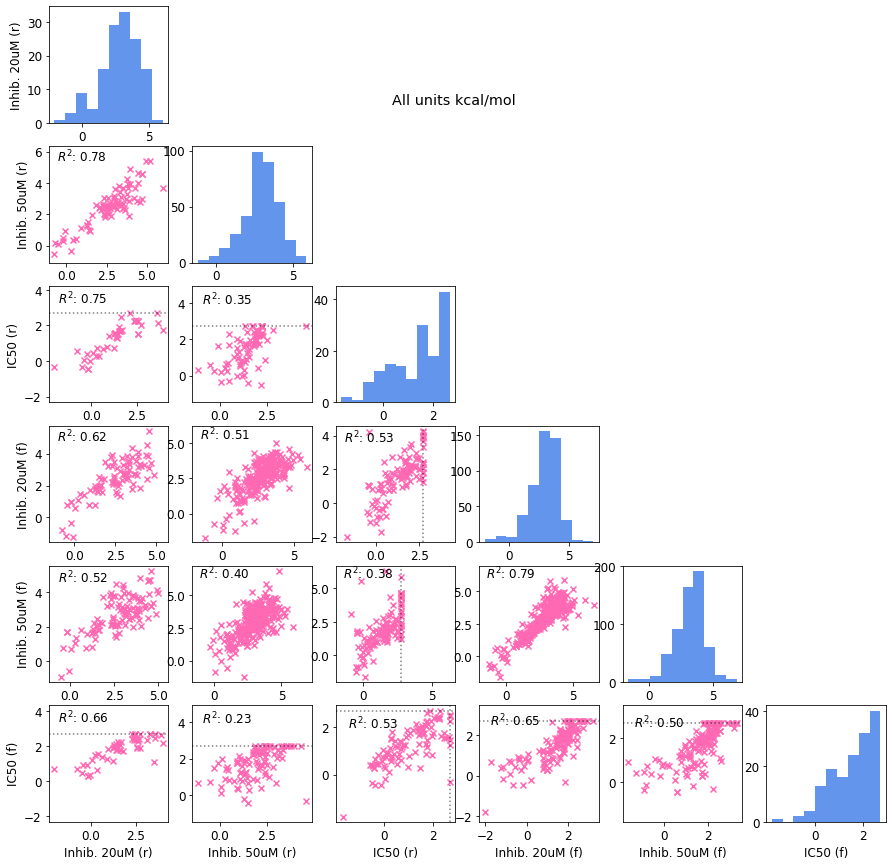

In [32]:
fig, axes = plt.subplots(ncols=6,nrows=6,figsize=(15,15))
import itertools
contents = ['r_inhib20uM','r_inhib50uM','r_IC50','f_inhib20uM','f_inhib50uM','f_IC50']
hist = {c:[] for c in contents}
scatters = {(j,i):[[],[]] for i,j in itertools.combinations(range(0,6),2)}

for exp in experimental.values():
    res = []
    for val in contents:
        if val in exp.keys():
            if 'IC50' in val:
                res.append(_ic50_to_dG(exp[val]))
            elif 'inhib20' in val and exp[val] > 0.:
                res.append(_inhibition_to_kd(exp[val],20))
            elif 'inhib50' in val and exp[val] > 0.:
                res.append(_inhibition_to_kd(exp[val],50))
            else:
                res.append(None)
        else:
            res.append(None)
            
    for i,c in enumerate(contents):
        if res[i] is not None:
            hist[c].append(res[i])

    for i,j in itertools.combinations(range(0,6),2):
        if res[i] is not None and res[j] is not None:
            scatters[(j,i)][0].append(res[i])
            scatters[(j,i)][1].append(res[j])
            
    contents_formal = ['Inhib. 20uM (r)','Inhib. 50uM (r)','IC50 (r)','Inhib. 20uM (f)','Inhib. 50uM (f)','IC50 (f)']
    for i,label in enumerate(contents_formal):
        axes[5][i].set_xlabel(f'{label}')
        axes[i][0].set_ylabel(f'{label}')
        
for i,c in enumerate(contents):
    axes[i][i].hist([x for x in hist[c] if x is not None and not np.isinf(x)],color='cornflowerblue')
    
limits = [_inhibition_to_kd(100.,20),_inhibition_to_kd(100.,50),_ic50_to_dG(99.),_inhibition_to_kd(100.,20),_inhibition_to_kd(100.,50),_ic50_to_dG(99.)]   

for i,j in itertools.combinations(range(0,6),2):
    xs = []
    ys = []
    for x,y in zip(scatters[(j,i)][0], scatters[(j,i)][1]):
        if x is not None and y is not None and not np.isinf(x) and not np.isinf(y):
            xs.append(x)
            ys.append(y)

    axes[j][i].scatter(xs,ys,color='hotpink',marker='x')
    s = stats.bootstrap_statistic(np.asarray(xs),np.asarray(ys), statistic='R2')
    string = f"$R^2$: {s['mle']:.2f}"  
    
    
    y_low, y_high = axes[j][i].get_ylim()
    x_low, x_high = axes[j][i].get_xlim()
    low = min(x_low,y_low)
    high = max(x_high,y_high)
    axes[j][i].text(low+0.5, high-1.,string)    

    axes[j][i].set_xlim(low,high)
    axes[j][i].set_ylim(low,high)
    axes[i][j].axis('off')
    
    # now plot the limits
    axes[j][i].hlines(limits[j],low,high,'k',linestyle=':',alpha=0.5)
    axes[j][i].vlines(limits[i],low,high,'k',linestyle=':',alpha=0.5)
plt.suptitle('All units kcal/mol',y=0.8)

plt.show()

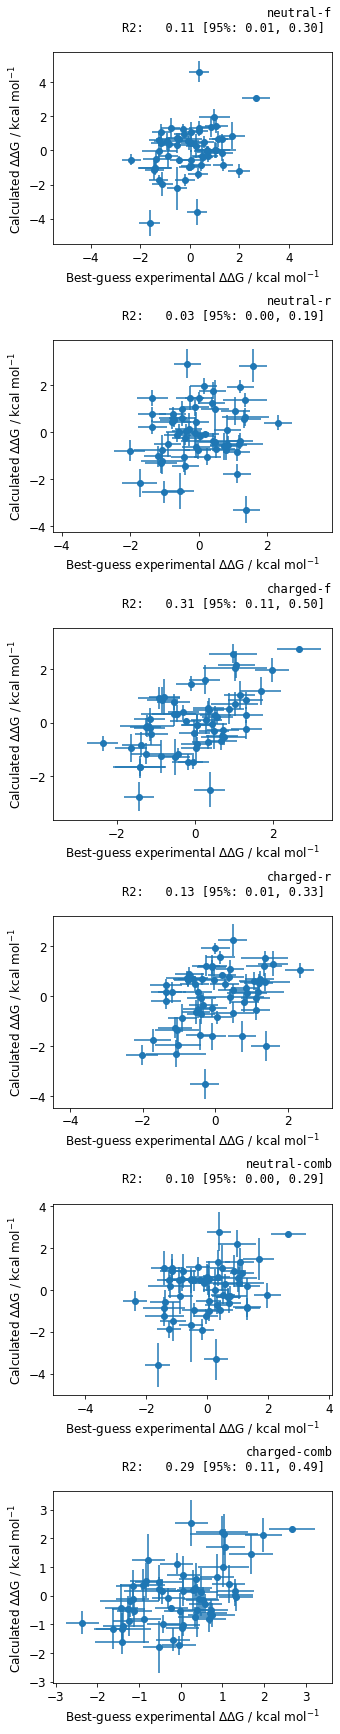

In [33]:
fig, axes = plt.subplots(ncols=1,nrows=len(graphs),figsize=(5, 5*len(graphs)))


for i, protein in enumerate(graphs.keys()):
    g = graphs[protein]
    xs = []
    x_err = []
    y_err = []
    ys = []
    for edge in g.edges(data=True):
        try:
            expt = nx.get_node_attributes(g,'DG')[edge[0]] - nx.get_node_attributes(g,'DG')[edge[1]]
            dexpt = (nx.get_node_attributes(g,'dDG')[edge[0]]**2 + nx.get_node_attributes(g,'dDG')[edge[1]]**2)**0.5
            ys.append(edge[2]['calc_DDG'])
            y_err.append(edge[2]['calc_dDDG'])
            xs.append(expt)
            x_err.append(dexpt)
        except:
            continue
    xs = xs - np.mean(xs)
    ys = ys - np.mean(ys)
    axes[i].scatter(xs,ys)
    axes[i].errorbar(xs,ys,xerr=x_err,yerr=y_err,ls='none')
    y_low, y_high = axes[i].get_ylim()
    x_low, x_high = axes[i].get_xlim()
    low = min(x_low,y_low)
    high = max(x_high,y_high)
    axes[i].set_xlim(low,high)
    axes[i].set_ylim(low,high)

    statistics_string = f'{protein}\n'
    for statistic in ['R2']:
        s = stats.bootstrap_statistic(np.asarray(xs),np.asarray(ys), statistic=statistic)
        string = f"{statistic}:   {s['mle']:.2f} [95%: {s['low']:.2f}, {s['high']:.2f}] " + "\n"
        statistics_string += string
    axes[i].set_title(statistics_string, fontsize=12, loc='right', horizontalalignment='right', family='monospace')

    axes[i].set_ylabel(f'Calculated ΔΔG '+r'/ kcal mol$^{-1}$')
    axes[i].set_xlabel(f'Best-guess experimental ΔΔG '+r'/ kcal mol$^{-1}$')

plt.subplots_adjust(hspace = 0.5,wspace = 0.5) 
plt.show()


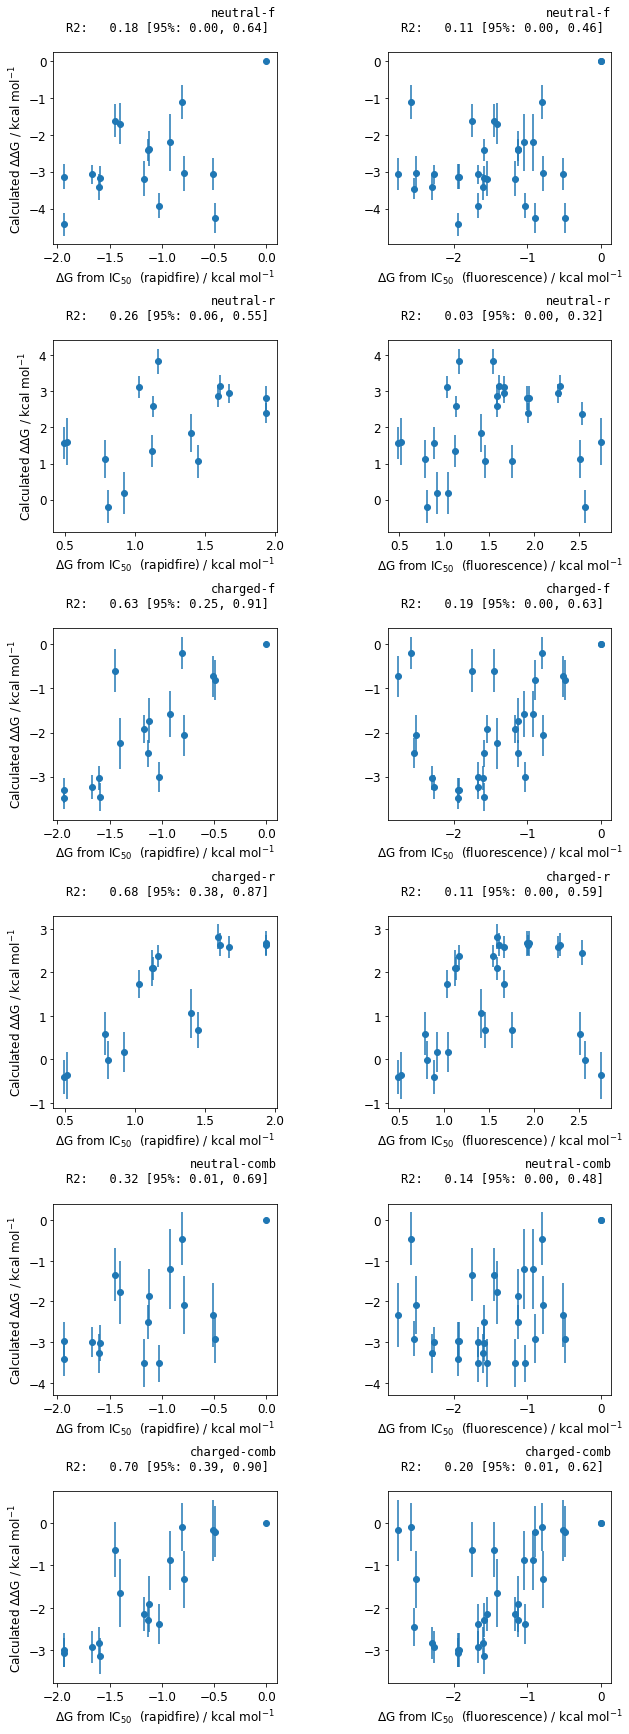

In [34]:
fig, axes = plt.subplots(ncols=2,nrows=len(graphs),figsize=(10, 5*len(graphs)))


for i, protein in enumerate(graphs.keys()):
    g = graphs[protein]
    xs = []
    y_err = []
    ys = []
    for j, assay in enumerate(['f','r']):
        for edge in g.edges(data=True):
            try:
                # TODO if either of these are 99, we want to color the associated datapoint different
                expt = nx.get_node_attributes(g,f'{assay}_IC50')[edge[0]] / nx.get_node_attributes(g,f'{assay}_IC50')[edge[1]]
                ys.append(edge[2]['calc_DDG'])
                y_err.append(edge[2]['calc_dDDG'])
                xs.append(0.59*np.log(expt))
            except:
                continue
        
        axes[i][j].scatter(xs,ys)
        axes[i][j].errorbar(xs,ys,yerr=y_err,ls='none')
#         low_lim, high_lim = axes[i][j].get_ylim()[0],axes[i][j].get_ylim()[1]
#         axes[i][j].vlines(0.59*np.log(99),low_lim, high_lim)
#         axes[i][j].set_ylim(low_lim, high_lim)
        
        statistics_string = f'{protein}\n'
        for statistic in ['R2']:
            s = stats.bootstrap_statistic(np.asarray(xs),np.asarray(ys), statistic=statistic)
            string = f"{statistic}:   {s['mle']:.2f} [95%: {s['low']:.2f}, {s['high']:.2f}] " + "\n"
            statistics_string += string
        axes[i][j].set_title(statistics_string, fontsize=12, loc='right', horizontalalignment='right', family='monospace')

    axes[i][0].set_ylabel(f'Calculated ΔΔG '+r'/ kcal mol$^{-1}$')
    axes[i][0].set_xlabel(r'ΔG from IC$_{50}$  (rapidfire) '+r'/ kcal mol$^{-1}$')
    axes[i][1].set_xlabel(r'ΔG from IC$_{50}$  (fluorescence) '+r'/ kcal mol$^{-1}$')
plt.subplots_adjust(hspace = 0.5,wspace = 0.5) 
plt.show()


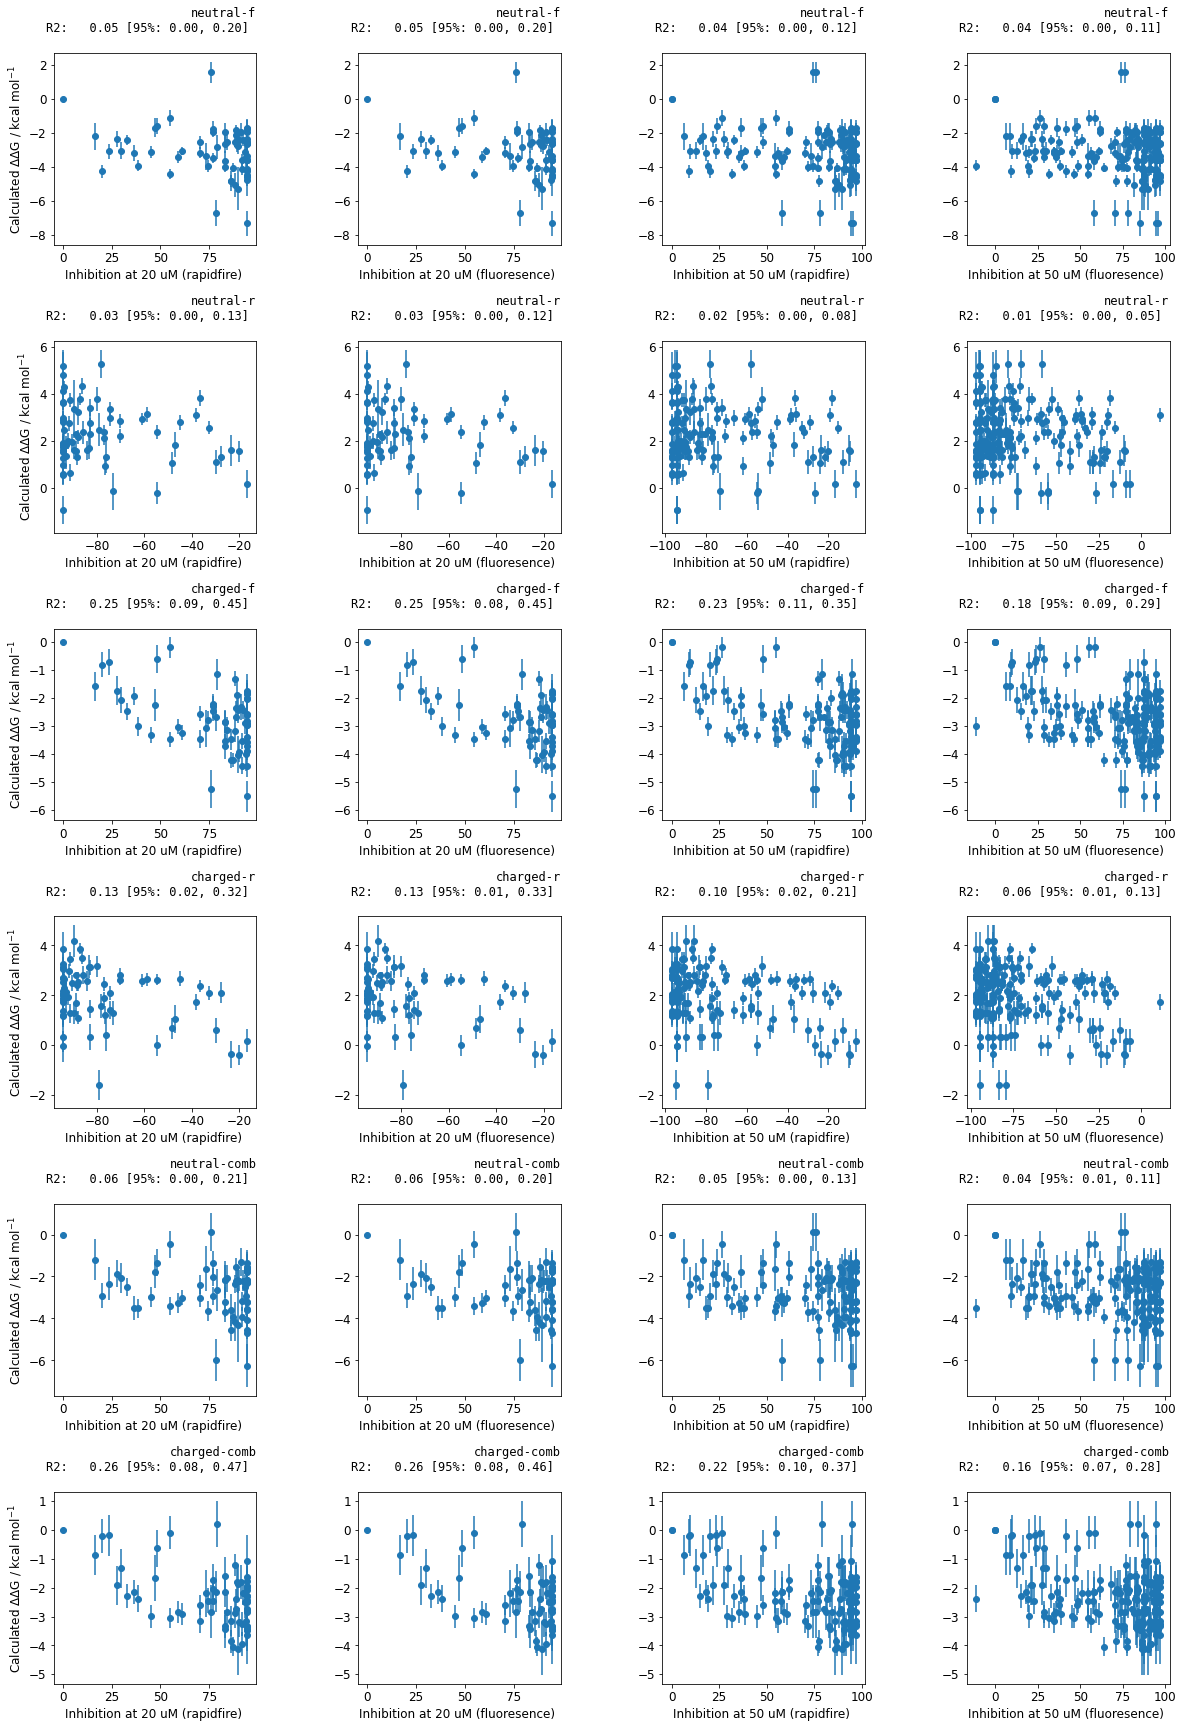

In [35]:
fig, axes = plt.subplots(ncols=4,nrows=len(graphs),figsize=(20, 5*len(graphs)))


for i, protein in enumerate(graphs.keys()):
    g = graphs[protein]
    xs = []
    y_err = []
    ys = []
    for j, assay in enumerate(['f_inhib20uM','r_inhib20uM','f_inhib50uM','r_inhib50uM']):
        for edge in g.edges(data=True):
            try:
                expt = nx.get_node_attributes(g,assay)[edge[0]] - nx.get_node_attributes(g,assay)[edge[1]]
                ys.append(edge[2]['calc_DDG'])
                y_err.append(edge[2]['calc_dDDG'])
                xs.append(expt)
            except:
                continue
        axes[i][j].scatter(xs,ys)
        axes[i][j].errorbar(xs,ys,yerr=y_err,ls='none')
        
        statistics_string = f'{protein}\n'
        for statistic in ['R2']:
            s = stats.bootstrap_statistic(np.asarray(xs),np.asarray(ys), statistic=statistic)
            string = f"{statistic}:   {s['mle']:.2f} [95%: {s['low']:.2f}, {s['high']:.2f}] " + "\n"
            statistics_string += string
        axes[i][j].set_title(statistics_string, fontsize=12, loc='right', horizontalalignment='right', family='monospace')

    axes[i][0].set_ylabel(f'Calculated ΔΔG '+r'/ kcal mol$^{-1}$')
    axes[i][0].set_xlabel(r'Inhibition at 20 uM (rapidfire) ')
    axes[i][1].set_xlabel(r'Inhibition at 20 uM (fluoresence) ')
    axes[i][2].set_xlabel(r'Inhibition at 50 uM (rapidfire) ')
    axes[i][3].set_xlabel(r'Inhibition at 50 uM (fluoresence) ')
plt.subplots_adjust(hspace = 0.5,wspace = 0.5) 
plt.show()


In [36]:
# # enumerated stereochemistry NEED TO COMBINE ESTIMATE FROM DIFFERENT STEREOCHEMISTRIES
# for title in title_to_index.keys():
#     print(title)

In [37]:
# def _inhibition_to_kd(percentage, concentration):
#     fraction = percentage / 100.
#     # using equation 7 from https://www.molbiolcell.org/doi/10.1091/mbc.e10-08-0683#F1
#     kd = concentration*((1 - fraction)/fraction)
#     return kd

# ### combining all
# for ligand in index_to_title.keys():
#     inhib = r_inhib_20[index_to_title[ligand]]
#     if inhib is not None and inhib > 0.:
#         kd_a = _inhibition_to_kd(inhib,20.)
#     else:
#         kd_a = None
#     inhib = r_inhib_50[index_to_title[ligand]]
#     if inhib is not None and inhib > 0.:
#         kd_b = _inhibition_to_kd(inhib,50.)
#     else:
#         kd_b = None
#     print(kd_a, kd_b, r_ic50[index_to_title[ligand]])

In [38]:
# enumerated stereochemistry

# for title in title_to_index.keys():
#     print(title)

TRY-UNI-2eddb1ff-7

In [46]:
fig1_left = {'L1':'ADA-UCB-6c2cb422-1',
'L2':'TRY-UNI-714a760b-6',
'L3':'EDG-MED-0da5ad92-2',
'L4':'JAN-GHE-5a013bed-2',
'L5':'JAN-GHE-5a013bed-3',
'L6':'JAN-GHE-5a013bed-1'}


fig1_right = {
'R1':'TRY-UNI-714a760b-6',
'R2':'JAN-GHE-83b26c96-12',
'R3':'TRY-UNI-714a760b-20',
'R4':'ALP-POS-95b75b4d-2',
'R5':'EDJ-MED-e58735b6-2'}


figure_1 = {**fig1_left, **fig1_right}
reverse = {j:i for i,j in figure_1.items()}

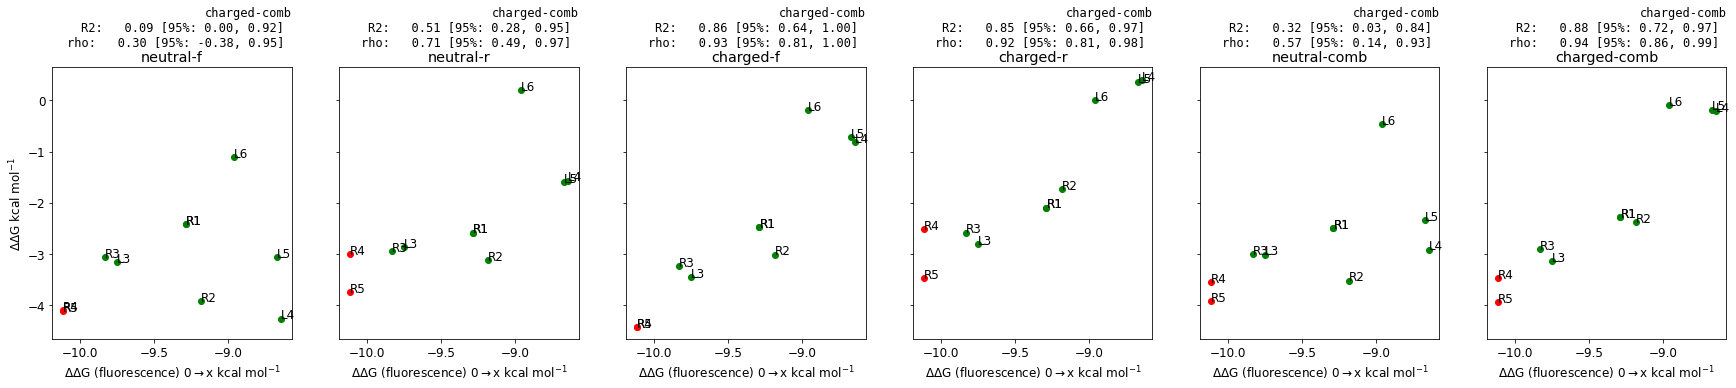

In [130]:
fig, axes = plt.subplots(ncols=6,nrows=1,figsize=(30,5),sharey=True)
ic50_0 = g.nodes.data()['TRY-UNI-2eddb1ff-7']['f_IC50']
plots = {}
for i,(t, g) in enumerate(graphs.items()):
    plots[i] = {'x':[],'y':[]}
    for edge in g.edges(data=True):
        for title in figure_1.values(): 
            if edge[1] == title:
                try:
                    x = _ic50_to_dG(ic50_0/g.nodes.data()[title]['f_IC50'])
                    y = edge[2]['calc_DDG']
                    axes[i].scatter(x,y,color='g')
                    axes[i].text(x,y,reverse[title])
                except:
                    x = _ic50_to_dG(ic50_0/99)
                    y = edge[2]['calc_DDG']
                    axes[i].scatter(x,y,color='r')
                    axes[i].text(x,y,reverse[title])
                plots[i]['x'].append(x)
                plots[i]['y'].append(y)
            if edge[0] == title:
                try:
                    x = _ic50_to_dG(ic50_0/g.nodes.data()[title]['f_IC50'])
                    y = -edge[2]['calc_DDG']
                    axes[i].scatter(x,y,color='g')
                    axes[i].text(x,y,reverse[title])
                except:
                    x = _ic50_to_dG(ic50_0/99)
                    y = -edge[2]['calc_DDG']
                    axes[i].scatter(x,y,color='r')
                    axes[i].text(x,y,reverse[title])
                plots[i]['x'].append(x)
                plots[i]['y'].append(y)
    axes[i].set_xlabel(r'$\Delta\Delta$G (fluorescence) 0$\rightarrow$x '+r'kcal mol$^{-1}$')
    axes[i].set_title(t)
    
for i in range(0,6):
    xs = plots[i]['x']
    ys = plots[i]['y']
    statistics_string = f'{protein}\n'
    for statistic in ['R2','rho']:
        s = stats.bootstrap_statistic(np.asarray(xs),np.asarray(ys), statistic=statistic)
        string = f"{statistic}:   {s['mle']:.2f} [95%: {s['low']:.2f}, {s['high']:.2f}] " + "\n"
        statistics_string += string
    axes[i].set_title(statistics_string, fontsize=12, loc='right', horizontalalignment='right', family='monospace')    

#     axes[i].set_xlim(-5,1)
#     axes[i].set_ylim(-5,1)
#     axes[i].plot([-5,1],[-5,1],linestyle=':',color='k')
axes[0].set_ylabel(r'$\Delta \Delta$G '+r'kcal mol$^{-1}$')
plt.show()

In [133]:
_ic50_to_dG(3.6/400)

-10.935869826353056

In [117]:
_ic50_to_dG(99)

2.705615228396366